In [ ]:
# importing the necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from math import ceil

In [ ]:
# connecting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# setting the device

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
# setting seed for reproducible results

seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# hyper-parameters

batch_size = 32
learning_rate = 0.001

In [ ]:
# mean, standard deviation for normalization

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
# transforms the image dataset

train_trans = transforms.Compose(
    [
     transforms.RandomResizedCrop((224,224)),   # resize
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)            # normalize for fear of light
                                                # exposure, noise, etc
    ]
)

val_trans = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.CenterCrop((224, 224)),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

In [ ]:
# getting the dataset

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/train',
                                 transform=train_trans,
                                 )

val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/val',
                                 transform=val_trans,
                                 )

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/test',
                                 transform=val_trans,
                                 )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

In [ ]:
# manually made efficientNet

class conv_block (nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding,
                              )

        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.silu = nn.SiLU()

        # efficientNet uses SiLU

    def forward(self, X):
        out = self.silu(self.bn(self.conv(X)))

        return out

class SElayer (nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SElayer, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(output_size=1)

        # excitation
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=in_channels,
                                out_features=in_channels//reduction)
        self.fc2 = nn.Linear(in_features=in_channels//reduction,
                             out_features=in_channels)

        self.sigmoid = nn.Sigmoid()

    def forward (self, X):

        out = self.squeeze(X)
        # batch_size, channel, _, _ = x.size()
        batch_size, channel, _, _ = X.shape

        out = out.reshape(out.shape[0], -1)
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        # out = out.view(batch_size, channel, 1, 1)
        out = out.reshape(batch_size, channel, 1, 1)

        # element-wise multiplied with X ???
        # out = out.expand(X.size())
        out = out.expand_as(X)

        return X * out

class depthwise_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride,
                 kernel_size, padding, groups=1,
                 act_type1=False):
        super(depthwise_block, self).__init__()

        assert act_type1 == True or act_type1 == False
        self.act_type = act_type1

        # dw

        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=in_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               groups=groups
                               )

        self.bn1 = nn.BatchNorm2d(num_features=in_channels)

        # mobilenet_v3 uses both Hardswish and ReLU

        if act_type1:
            self.relu = nn.ReLU6()

        self.hardswish = nn.Hardswish()

        # pw

        self.conv2 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=(1, 1),
                               stride=(1, 1),
                               padding=(0, 0),
                               )
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, X):

        if self.act_type:
            out = self.relu(self.bn1(self.conv1(X)))
        else:
            out = self.hardswish(self.bn1(self.conv1(X)))

        out = self.bn2(self.conv2(out))

        # mobilev2 doesnt have relu in pw

        return out

class InvertedResidual_block (nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, padding, block_type1=False,
                 expand_ratio=6, act_type_=False, use_se=False,
                 survival_prob=0.8):

        super(InvertedResidual_block, self).__init__()

        assert block_type1 == True or block_type1 == False
        assert use_se == True or use_se == False
        self.block_type = block_type1
        self.se_layer = use_se
        self.survival_prob = 0.8

        # expansion

        self.conv1 = conv_block(in_channels=in_channels,
                               out_channels=in_channels*expand_ratio,
                                kernel_size=(1,1),
                               stride=(1,1),
                                padding=(0,0))

        # depthwise_block = depthwise + pointwise

        self.convdw = depthwise_block(in_channels=in_channels*expand_ratio,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=padding,
                                      groups=in_channels*expand_ratio,
                                      act_type1=act_type_)

        if block_type1:
            self.padd_conv = nn.Conv2d(in_channels=in_channels,
                                       out_channels=out_channels,
                                       kernel_size=(1, 1),
                                       stride=(1, 1),
                                       padding=(0, 0))

        if use_se:
            self.se = SElayer(in_channels=out_channels, reduction=16)


    def stochastic_depth (self, X):
        if not self.training:
            return X

        binary_tensor = torch.randn(X.shape[0], 1, 1, 1,
                                    device=X.device) < self.survival_prob

        return torch.div(X, self.survival_prob) * binary_tensor

    def forward(self, X):

        out = self.conv1(X)     # expand
        out = self.convdw(out)  # depthwise_block

        if self.se_layer:
            out = self.se(out)

        if self.block_type:     # if use residual
            out = self.stochastic_depth(out)
            X = self.padd_conv(X)
            out += X
            return out
        else:
            return out

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class efficientNet (nn.Module):

    def __init__(self, version, num_classes):
        super(efficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.cal_factors(version)

        self.depth_factor = depth_factor

        self.first_layer = conv_block(in_channels=3,
                                      out_channels=int(32*width_factor),
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=(1, 1))

        self.first_layer_n = conv_block(in_channels=int(32*width_factor),
                                      out_channels=int(32 * width_factor),
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=(1, 1))

        self.mbconv1 = InvertedResidual_block(in_channels=int(32*width_factor),
                                              out_channels=int(16*width_factor),
                                              kernel_size=(3, 3),
                                              stride=(2, 2),
                                              padding=(1, 1),
                                              block_type1=False,
                                              expand_ratio=1,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv1_n = InvertedResidual_block(in_channels=int(16 * width_factor),
                                              out_channels=int(16 * width_factor),
                                              kernel_size=(3, 3),
                                              stride=(1, 1),
                                              padding=(1, 1),
                                              block_type1=True,
                                              expand_ratio=1,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv2 = InvertedResidual_block(in_channels=int(16 * width_factor),
                                              out_channels=int(24 * width_factor),
                                              kernel_size=(3, 3),
                                              stride=(1, 1),
                                              padding=(1, 1),
                                              block_type1=True,
                                              expand_ratio=6,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv2_n = InvertedResidual_block(in_channels=int(24 * width_factor),
                                              out_channels=int(24 * width_factor),
                                              kernel_size=(3, 3),
                                              stride=(1, 1),
                                              padding=(1, 1),
                                              block_type1=True,
                                              expand_ratio=6,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv3 = InvertedResidual_block(in_channels=int(24 * width_factor),
                                              out_channels=int(40 * width_factor),
                                              kernel_size=(5, 5),
                                              stride=(2, 2),
                                              padding=(2, 2),
                                              block_type1=False,
                                              expand_ratio=6,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv3_n = InvertedResidual_block(in_channels=int(40 * width_factor),
                                              out_channels=int(40 * width_factor),
                                              kernel_size=(5, 5),
                                              stride=(1, 1),
                                              padding=(2, 2),
                                              block_type1=True,
                                              expand_ratio=6,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv4 = InvertedResidual_block(in_channels=int(40 * width_factor),
                                              out_channels=int(80 * width_factor),
                                              kernel_size=(3, 3),
                                              stride=(2, 2),
                                              padding=(1, 1),
                                              block_type1=False,
                                              expand_ratio=6,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv4_n = InvertedResidual_block(in_channels=int(80 * width_factor),
                                              out_channels=int(80 * width_factor),
                                              kernel_size=(3, 3),
                                              stride=(1, 1),
                                              padding=(1, 1),
                                              block_type1=True,
                                              expand_ratio=6,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv5 = InvertedResidual_block(in_channels=int(80 * width_factor),
                                              out_channels=int(112 * width_factor),
                                              kernel_size=(5, 5),
                                              stride=(2, 2),
                                              padding=(2, 2),
                                              block_type1=False,
                                              expand_ratio=6,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv5_n = InvertedResidual_block(in_channels=int(112 * width_factor),
                                              out_channels=int(112 * width_factor),
                                              kernel_size=(5, 5),
                                              stride=(1, 1),
                                              padding=(2, 2),
                                              block_type1=True,
                                              expand_ratio=6,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv6 = InvertedResidual_block(in_channels=int(112 * width_factor),
                                              out_channels=int(192 * width_factor),
                                              kernel_size=(5, 5),
                                              stride=(1, 1),
                                              padding=(2, 2),
                                              block_type1=True,
                                              expand_ratio=6,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv6_n = InvertedResidual_block(in_channels=int(192 * width_factor),
                                              out_channels=int(192 * width_factor),
                                              kernel_size=(5, 5),
                                              stride=(1, 1),
                                              padding=(2, 2),
                                              block_type1=True,
                                              expand_ratio=6,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.mbconv7 = InvertedResidual_block(in_channels=int(192 * width_factor),
                                              out_channels=int(320 * width_factor),
                                              kernel_size=(3, 3),
                                              stride=(2, 2),
                                              padding=(1, 1),
                                              block_type1=False,
                                              expand_ratio=6,
                                              act_type_=False,
                                              use_se=True
                                              )

        self.avgpool = nn.AvgPool2d(kernel_size=(7, 7),
                                    stride=(1, 1),
                                    padding=(0, 0))

        self.silu = nn.SiLU()

        self.fc1 = nn.Linear(in_features=int(320 * width_factor),
                             out_features=int(1280 * width_factor))

        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(in_features=int(1280 * width_factor),
                             out_features=num_classes)

    def cal_factors(self, version, alpha=1.2, beta=1.1):

        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi

        return width_factor, depth_factor, drop_rate

    def forward(self, X):

        out = self.first_layer(X) # 3 --> 32
        num_repeat = ceil(1 * self.depth_factor)

        for layer in range(num_repeat - 1):
            out = self.first_layer_n(out)

        out = self.mbconv1(out) # 32 --> 16

        for layer in range(num_repeat-1):
            out = self.mbconv1_n(out)

        out = self.mbconv2(out) # 16 --> 24

        for layer in range(num_repeat-1):
            out = self.mbconv2_n(out)

        out = self.mbconv3(out) # 24 --> 40
        num_repeat = ceil(2 * self.depth_factor)

        for layer in range(num_repeat-1):
            out = self.mbconv3_n(out)

        out = self.mbconv4(out)  # 40 --> 80
        num_repeat = ceil(3 * self.depth_factor)

        for layer in range(num_repeat-1):
            out = self.mbconv4_n(out)

        out = self.mbconv5(out) # 80 --> 112
        for layer in range(num_repeat-1):
            out = self.mbconv5_n(out)

        out = self.mbconv6(out)  # 112 --> 192
        num_repeat = ceil(4 * self.depth_factor)

        for layer in range(num_repeat-1):
            out = self.mbconv6_n(out)

        out = self.mbconv7(out)

        out = self.avgpool(out)

        out = out.reshape(out.shape[0], -1)
        out = self.silu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [ ]:
# calling the model

model = efficientNet(version="b0",
                 num_classes=2).to(device)

In [ ]:
# setting the loss metric and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# open this block for training on checkpoint
# checkpoint = torch.load('/content/drive/MyDrive/mobilenetv1_on_hymeno.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['model_optimizer'])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# tuning the learning rate

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# measuring time taken running the epochs

def calculate_time (time_elapsed):
    minutes = time_elapsed // 60
    seconds = time_elapsed % 60
    if minutes > 60:
        hours = minutes // 60
        new_minutes = minutes % 60
        print(f'Training complete in {hours:.0f}h {new_minutes:.0f}m {seconds:.0f}s')
    else:
        print(f'Training complete in {minutes:.0f}m {seconds:.0f}s')

In [ ]:
# hyper-parameters

num_epochs = 30
val_acc_hist = []
train_acc_hist = []
loss_train = []
loss_val = []
best_acc = 0.0

In [ ]:
# training loop

start = time.time()

for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0
    running_corrects = 0

    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        z_scores = model(images)
        loss = criterion(z_scores, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predictions = torch.max(z_scores, 1)
        running_corrects += torch.sum(predictions == labels)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    print(f'Epoch {epoch+1} / {num_epochs}, '
          f'Train Loss {epoch_loss:.4f}, '
          f'Train Acc {epoch_acc:.4f}')

    train_acc_hist.append(epoch_acc)
    loss_train.append(epoch_loss)

    step_lr_scheduler.step()

    model.eval()

    running_loss = 0.0
    running_corrects = 0

    for idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            z_scores = model(images)
            loss = criterion(z_scores, labels)

            running_loss += loss.item() * images.size(0)
            _, predictions = torch.max(z_scores, 1)
            running_corrects += torch.sum(predictions == labels)

    epoch_loss_val = running_loss / len(val_dataset)
    epoch_acc_val = running_corrects / len(val_dataset)
    print(f'Epoch {epoch + 1} / {num_epochs}, '
          f'Val Loss {epoch_loss_val:.4f}, '
          f'Val Acc {epoch_acc_val:.4f}')

    val_acc_hist.append(epoch_acc_val)
    loss_val.append(epoch_loss_val)

    if epoch_acc_val > best_acc:
        best_acc = epoch_acc_val

time_elapsed = time.time() - start

Epoch 1 / 30, Train Loss 0.7346, Train Acc 0.4877
Epoch 1 / 30, Val Loss 0.6897, Val Acc 0.5699
Epoch 2 / 30, Train Loss 0.7370, Train Acc 0.4877
Epoch 2 / 30, Val Loss 0.6929, Val Acc 0.5699
Epoch 3 / 30, Train Loss 0.7130, Train Acc 0.5041
Epoch 3 / 30, Val Loss 0.7100, Val Acc 0.4301
Epoch 4 / 30, Train Loss 0.7300, Train Acc 0.5082
Epoch 4 / 30, Val Loss 0.6996, Val Acc 0.4301
Epoch 5 / 30, Train Loss 0.7053, Train Acc 0.4877
Epoch 5 / 30, Val Loss 0.6898, Val Acc 0.5699
Epoch 6 / 30, Train Loss 0.7203, Train Acc 0.5000
Epoch 6 / 30, Val Loss 0.6999, Val Acc 0.4301
Epoch 7 / 30, Train Loss 0.6878, Train Acc 0.5410
Epoch 7 / 30, Val Loss 0.7126, Val Acc 0.4301
Epoch 8 / 30, Train Loss 0.6962, Train Acc 0.5410
Epoch 8 / 30, Val Loss 0.7152, Val Acc 0.4301
Epoch 9 / 30, Train Loss 0.6974, Train Acc 0.4877
Epoch 9 / 30, Val Loss 0.7122, Val Acc 0.4301
Epoch 10 / 30, Train Loss 0.6880, Train Acc 0.5328
Epoch 10 / 30, Val Loss 0.7138, Val Acc 0.4301
Epoch 11 / 30, Train Loss 0.7029, Trai

In [ ]:
calculate_time(time_elapsed)

Training complete in 6m 39s


In [ ]:
print(f'Best validation Accuracy: {best_acc:.4f}')

Best validation Accuracy: 0.5699


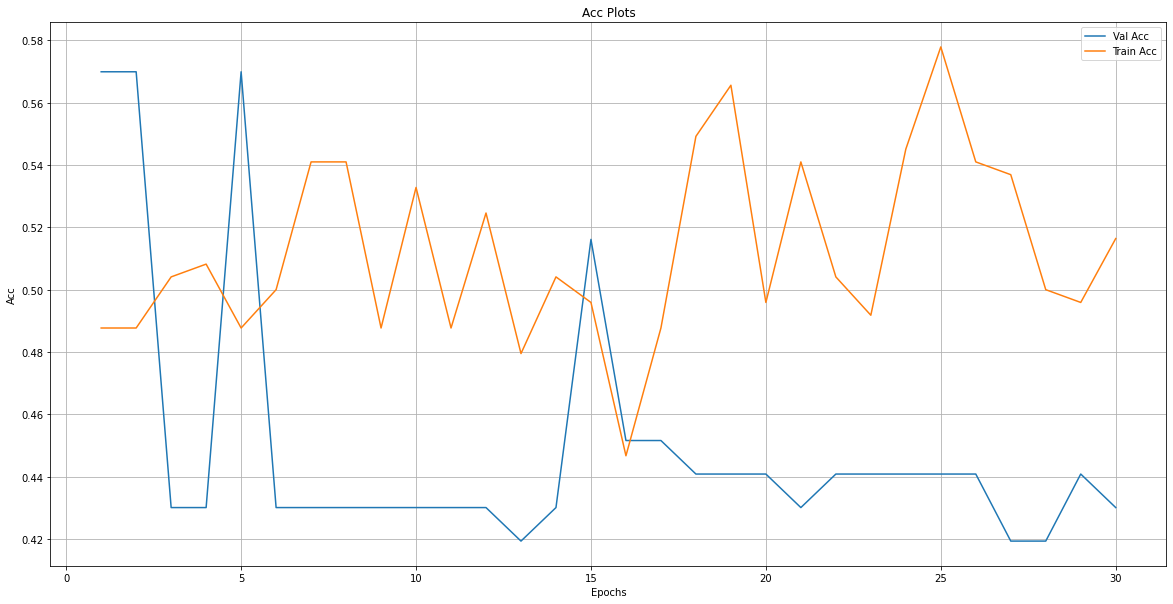

In [ ]:
# visualizing training and validating accuracy

val_acc_hist_numpy = [acc.cpu().numpy() for acc in val_acc_hist]
train_acc_hist_numpy = [acc.cpu().numpy() for acc in train_acc_hist]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), val_acc_hist_numpy, label='Val Acc')
plt.plot(range(1, num_epochs+1), train_acc_hist_numpy, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title("Acc Plots")
plt.legend(loc='upper right')
plt.show()

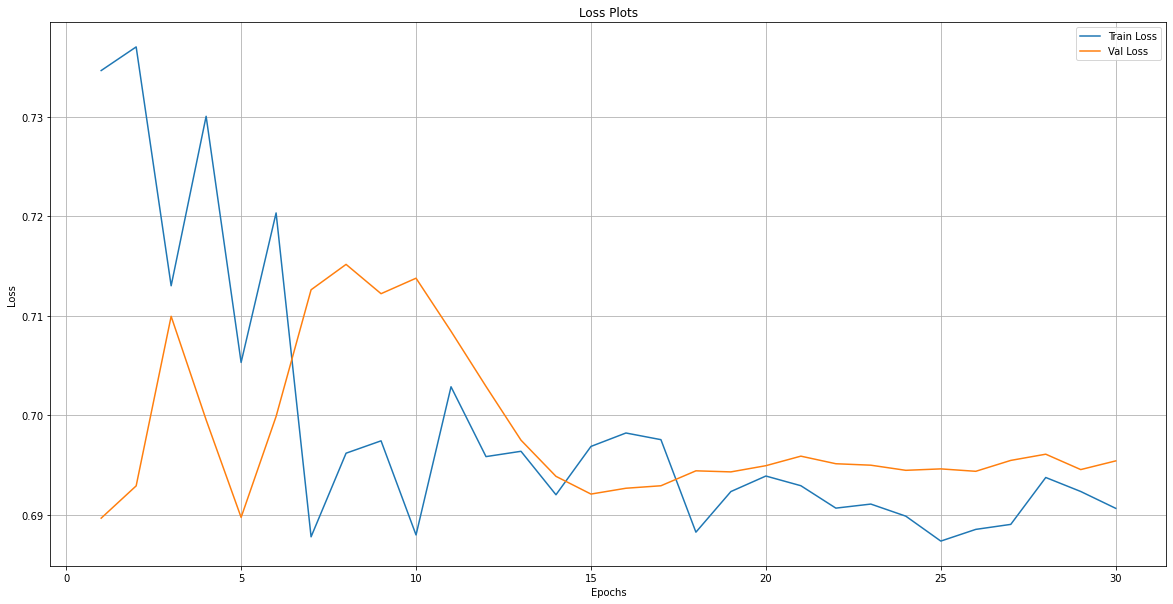

In [ ]:
# visualizing training and validating loss

plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), loss_train, label='Train Loss')
plt.plot(range(1, num_epochs+1), loss_val, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
# testing the model

model.eval()

running_corrects = 0

with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        z_scores = model(images)

        _, predictions = torch.max(z_scores,1)
        running_corrects += torch.sum(predictions == labels)

    acc = running_corrects / len(test_dataset)
    print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.5333


In [ ]:
# saving model

checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_optimizer': optimizer.state_dict(),
                'val_acc_hist': val_acc_hist,
                'train_acc_hist': train_acc_hist,
                'loss_train': loss_train,
                'loss_val': loss_val,
                'best_acc': best_acc
}

torch.save(checkpoint, '/content/drive/MyDrive/efficientNet_on_hymeno.pth')